Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [146]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
import warnings
warnings.filterwarnings('ignore')

In [ ]:
## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')
#!unzip gdrive/MyDrive/CNN_assignment
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166


%rm -rf 'Skin cancer ISIC The International Skin Imaging Collaboration'
!gdown --id 1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs
!unzip -o -q CNN_assignment.zip

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [106]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [107]:
!ls

 CNN_assignment.zip
 model_plot.png
 sample_data
'Skin cancer ISIC The International Skin Imaging Collaboration'


In [108]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [109]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [110]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [111]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [112]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

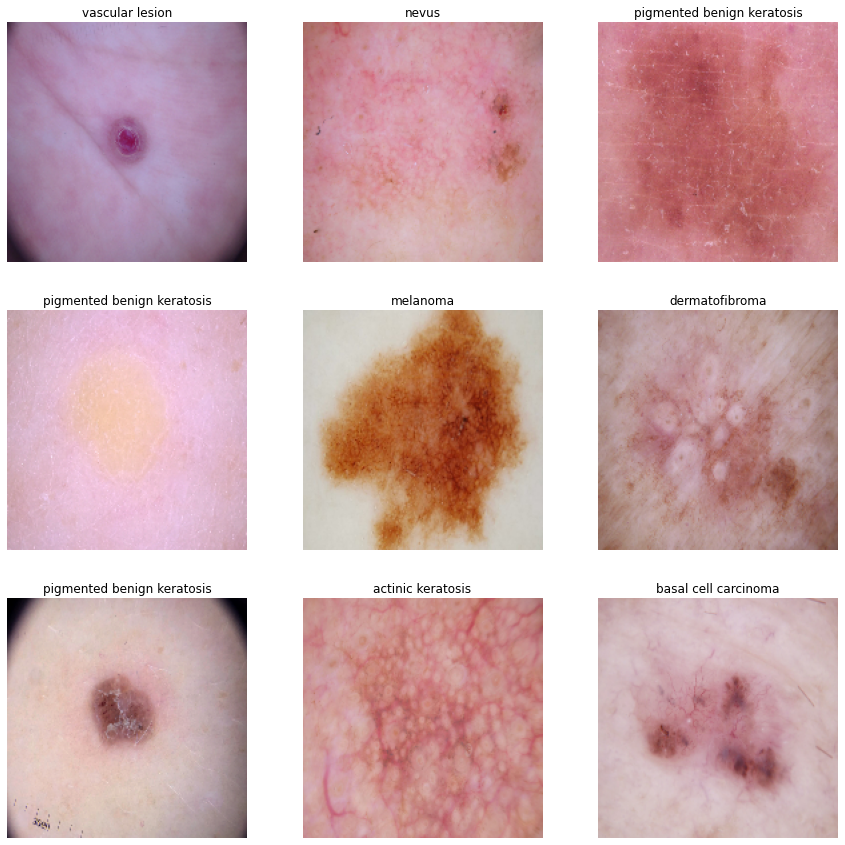

In [113]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [114]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [115]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [116]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [117]:
# View the summary of all layers
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_19 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_57 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 45, 45, 64)      

### Train the model

In [118]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 14s 70ms/step - loss: 1.8175 - accuracy: 0.3158 - val_loss: 1.6135 - val_accuracy: 0.4430
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5158 - accuracy: 0.4648 - val_loss: 1.5130 - val_accuracy: 0.4922
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3949 - accuracy: 0.5089 - val_loss: 1.3946 - val_accuracy: 0.4944
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2901 - accuracy: 0.5474 - val_loss: 1.3601 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1835 - accuracy: 0.5820 - val_loss: 1.4396 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.0999 - accuracy: 0.6088 - val_loss: 1.3980 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.0016 - accuracy: 0.6323 - val_loss: 1.4212 - val_accuracy: 0.5324
Epoch 8/20
5

### Visualizing training results

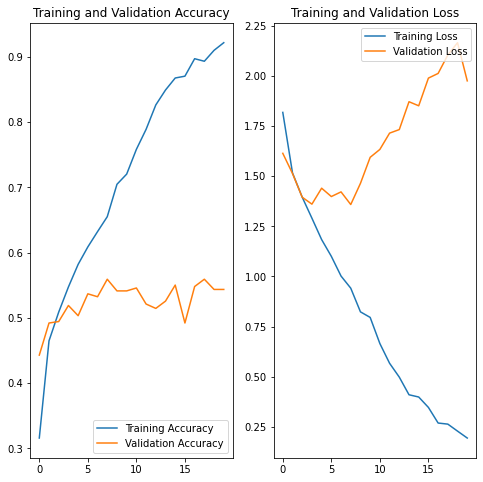

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

####  From above graph, training accuracy = 92% but validation accuracy = 54% which is indicating overfitting 

In [120]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("vertical", input_shape=(img_height, img_width, 3)),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
])

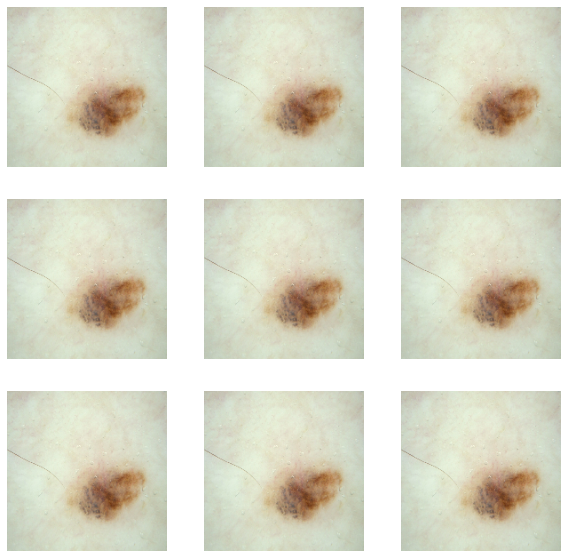

In [121]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [122]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [123]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [124]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 43ms/step - loss: 2.0079 - accuracy: 0.2985 - val_loss: 1.6843 - val_accuracy: 0.4049
Epoch 2/20
56/56 [==============================] - 2s 40ms/step - loss: 1.6205 - accuracy: 0.4319 - val_loss: 1.5566 - val_accuracy: 0.4609
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5515 - accuracy: 0.4448 - val_loss: 1.5044 - val_accuracy: 0.4676
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4606 - accuracy: 0.4855 - val_loss: 1.7323 - val_accuracy: 0.4318
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4969 - accuracy: 0.4794 - val_loss: 1.4702 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4127 - accuracy: 0.5022 - val_loss: 1.3819 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3310 - accuracy: 0.5279 - val_loss: 1.4481 - val_accuracy: 0.5034
Epoch 8/20
56

### Visualizing the results

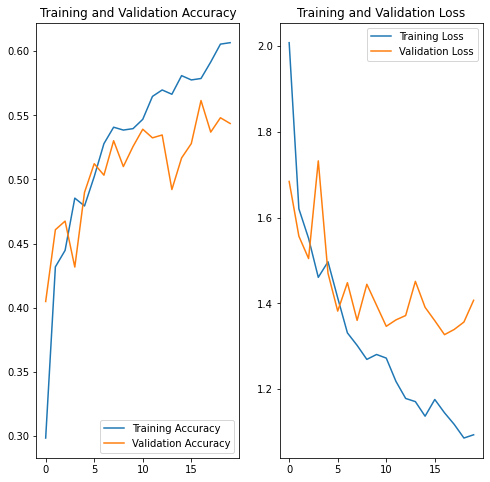

In [125]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Comment:
        
        - After using augumentation data there is improvement now as compared to the previous model run.

        - Model is still performing poorly on both trainng and validation data

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [126]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

img_df = original_df[['Label']].value_counts().rename_axis('class_name').reset_index(name='count')
img_df


,class_name,count
0,pigmented benign keratosis,462
1,melanoma,438
2,basal cell carcinoma,376
3,nevus,357
4,squamous cell carcinoma,181
5,vascular lesion,139
6,actinic keratosis,114
7,dermatofibroma,95
8,seborrheic keratosis,77


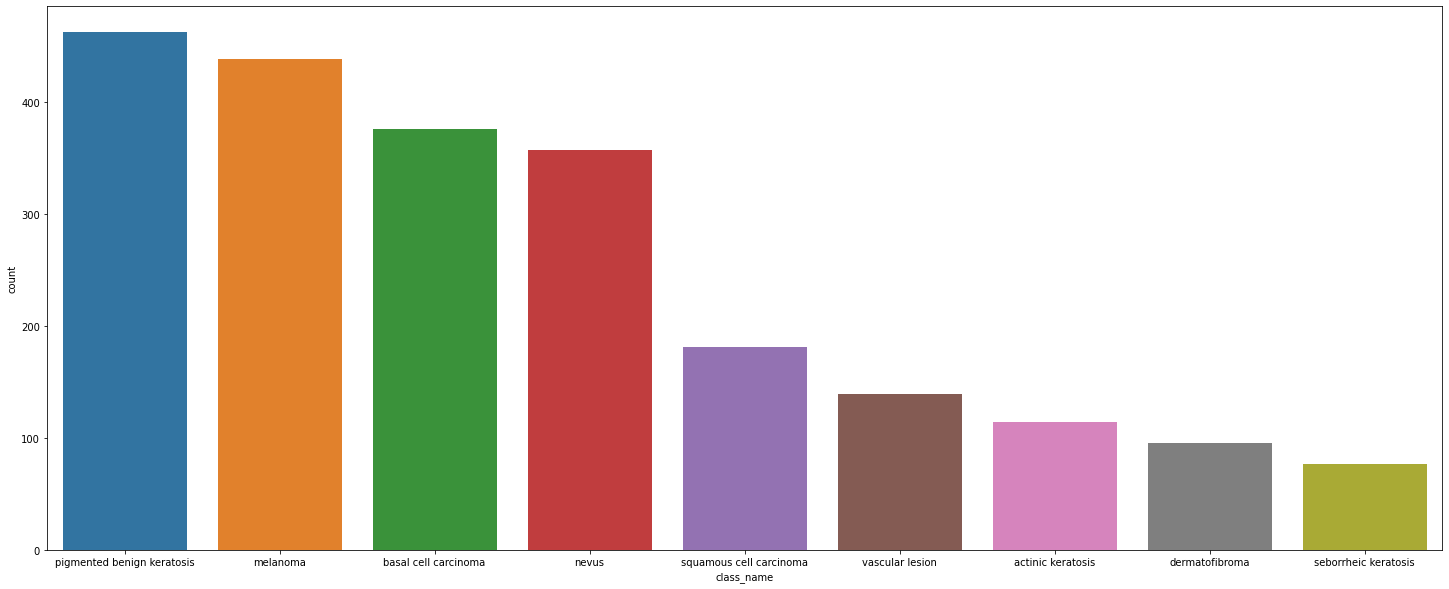

In [127]:
import seaborn as sns
plt.figure(figsize=(25,10))
sns.barplot(x= 'class_name', y = 'count', data=img_df)
plt.show()


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
####  - seborrheic keratosis (77 images)	 
#### - Which classes dominate the data in terms proportionate number of samples?
####  - pigmented benign keratosis(462),melanoma(438),basal cell carcinoma(376),nevus(357)


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [128]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [129]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F90363E0110>: 100%|██████████| 500/500 [00:16<00:00, 29.91 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9034347F50>: 100%|██████████| 500/500 [00:18<00:00, 27.24 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9034304890>: 100%|██████████| 500/500 [00:19<00:00, 25.23 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=962x674 at 0x7F90364C1C90>: 100%|██████████| 500/500 [01:41<00:00,  4.92 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F9034405DD0>: 100%|██████████| 500/500 [01:19<00:00,  6.29 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F90A050CBD0>: 100%|██████████| 500/500 [00:16<00:00, 30.23 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F904C096F10>: 100%|██████████| 500/500 [00:38<00:00, 12.97 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F903433B310>: 100%|██████████| 500/500 [00:16<00:00, 30.99 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F90346FEB50>: 100%|██████████| 500/500 [00:16<00:00, 30.92 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [130]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [131]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new


['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026417.jpg_6393d119-3431-4b76-8d46-713291129d58.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030021.jpg_5a40a23f-d1d4-44c6-92d7-74805940b7f2.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029891.jpg_07c286dc-b025-4016-a62d-00cb7e330a9e.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031271.jpg_685d4c36-2404-45b2-aa10-c464b8afb8ed.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029297.jpg_913fa63a-9e95-49bc-8652-5b3732a76fcf.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Tr

In [132]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [133]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [134]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [135]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [136]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [137]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [138]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [139]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [140]:
## your code goes here
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding = 'same', activation='relu'),
  layers.MaxPooling2D(),

  layers.BatchNormalization(),
  layers.Conv2D(256, 3, padding = 'same', activation='relu'),
  layers.MaxPooling2D(),
 
  layers.BatchNormalization(),
  layers.Conv2D(512, 3, padding = 'same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Flatten(),

  layers.BatchNormalization(),
  layers.Dense(128, activation='relu'),
  
  layers.BatchNormalization(),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.4),

  layers.Dense(num_classes)
])

In [141]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [142]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 64s 229ms/step - loss: 1.8820 - accuracy: 0.3353 - val_loss: 3.2016 - val_accuracy: 0.1158
Epoch 2/30
169/169 [==============================] - 36s 211ms/step - loss: 1.4632 - accuracy: 0.4638 - val_loss: 1.9519 - val_accuracy: 0.2814
Epoch 3/30
169/169 [==============================] - 36s 215ms/step - loss: 1.2724 - accuracy: 0.5336 - val_loss: 1.1598 - val_accuracy: 0.5754
Epoch 4/30
169/169 [==============================] - 36s 213ms/step - loss: 1.1033 - accuracy: 0.5938 - val_loss: 0.9303 - val_accuracy: 0.6763
Epoch 5/30
169/169 [==============================] - 36s 213ms/step - loss: 0.9662 - accuracy: 0.6465 - val_loss: 0.8649 - val_accuracy: 0.6793
Epoch 6/30
169/169 [==============================] - 36s 214ms/step - loss: 0.8397 - accuracy: 0.6981 - val_loss: 0.7615 - val_accuracy: 0.7253
Epoch 7/30
169/169 [==============================] - 36s 214ms/step - loss: 0.7323 - accuracy: 0.7329 - val_loss: 0.7668 - val_ac

#### **Todo:**  Visualize the model results

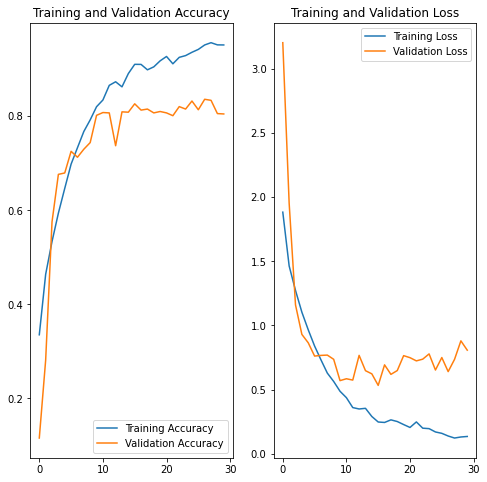

In [143]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

## Commemts
##### In the final model, there is no sign of underfitting/overfitting.
##### Class rebalanced improved the model performance on both training and validation data.




In [144]:
print("-----------------------   Accuracy  ----------------------- ")

print("Accuracy            : ", acc[-1])
print("Validation Accuracy : ",val_acc[-1])
print("Loss                : ",loss[-1])
print("Validation Loss     : ", val_loss[-1]) 

-----------------------   Accuracy  ----------------------- 
Accuracy            :  0.9514095187187195
Validation Accuracy :  0.8047512769699097
Loss                :  0.13551045954227448
Validation Loss     :  0.8074936866760254


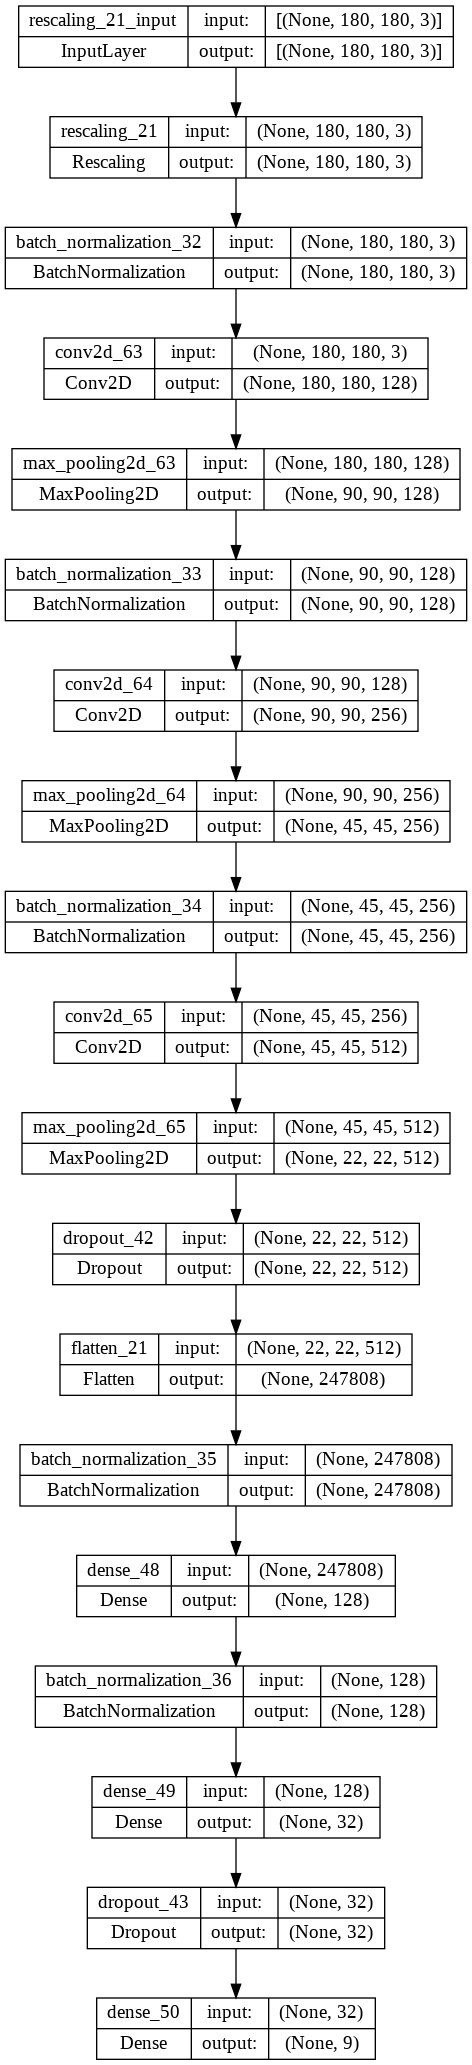

In [145]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)